# Image Classification using CNN

# dataset: CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Data transforms (normalization & data augmentation)

In [2]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transforms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(), 
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])
valid_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

In [3]:
# load CIFAR10 with torchvision
"""
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
"""

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=valid_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


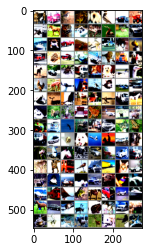

cat   car   bird  frog  dog   bird  car   truck plane horse cat   ship  frog  deer  deer  car   ship  dog   car   deer  plane car   dog   bird  truck frog  plane plane car   dog   truck dog   horse car   frog  truck cat   dog   plane bird  bird  deer  plane truck bird  cat   plane car   truck deer  cat   horse deer  plane truck horse ship  deer  bird  truck frog  plane deer  deer  frog  ship  bird  deer  truck ship  cat   frog  truck car   cat   dog   plane horse plane cat   frog  plane dog   horse car   deer  car   truck frog  cat   truck bird  car   truck cat   car   deer  cat   ship  cat   car   truck bird  dog   plane truck bird  frog  horse car   plane ship  horse car   frog  deer  frog  dog   car   cat   frog  cat   deer  deer  deer  truck bird  plane


In [4]:
# visulaize some of the training images
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Implement a CNN

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [8]:
model = Cifar10CnnModel()

use gpu

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)
to_device(model, device);

# Train the model

In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
model = to_device(Cifar10CnnModel(), device)

Evaluate the model with randomly created weights. The accuracy is 10%, which makes sense since we have 10 classes.

In [14]:
evaluate(model, testloader)

{'val_loss': 2.3029444217681885, 'val_acc': 0.10096914321184158}

hyperparameters

In [15]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

In [16]:
import time
start_time = time.time()

In [17]:
history = fit(num_epochs, lr, model, trainloader, testloader, opt_func)

Epoch [0], train_loss: 1.4325, val_loss: 1.1516, val_acc: 0.5873
Epoch [1], train_loss: 0.9808, val_loss: 1.0749, val_acc: 0.6357
Epoch [2], train_loss: 0.7950, val_loss: 0.7567, val_acc: 0.7443
Epoch [3], train_loss: 0.6772, val_loss: 0.6795, val_acc: 0.7639
Epoch [4], train_loss: 0.5998, val_loss: 0.5581, val_acc: 0.8111
Epoch [5], train_loss: 0.5342, val_loss: 0.6258, val_acc: 0.7901
Epoch [6], train_loss: 0.4891, val_loss: 0.5240, val_acc: 0.8248
Epoch [7], train_loss: 0.4511, val_loss: 0.5309, val_acc: 0.8151
Epoch [8], train_loss: 0.4211, val_loss: 0.4448, val_acc: 0.8506
Epoch [9], train_loss: 0.3914, val_loss: 0.4152, val_acc: 0.8630
Epoch [10], train_loss: 0.3619, val_loss: 0.4439, val_acc: 0.8547
Epoch [11], train_loss: 0.3398, val_loss: 0.4300, val_acc: 0.8516
Epoch [12], train_loss: 0.3161, val_loss: 0.3927, val_acc: 0.8685
Epoch [13], train_loss: 0.3017, val_loss: 0.4305, val_acc: 0.8611
Epoch [14], train_loss: 0.2818, val_loss: 0.3914, val_acc: 0.8741
Epoch [15], train_lo

In [18]:
elapsed_time = time.time() - start_time
elapsed_time

483.56108570098877

plot the valiadation accuracies

In [19]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

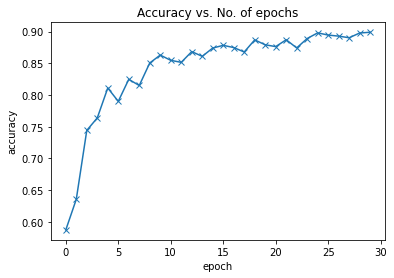

In [20]:
plot_accuracies(history)

plot the training and validation losses

In [21]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

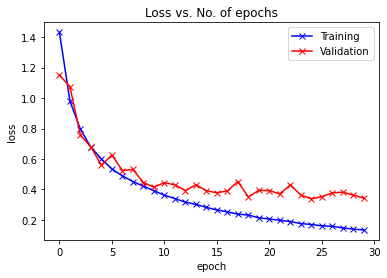

In [22]:
plot_losses(history)

In [23]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        total_params+=params
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

Total Trainable Params: 5853066


5853066